In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import zipfile
import os
from tqdm import tqdm

import kagglehub

# --- Added for hybrid classifiers ---
from time import perf_counter
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, roc_auc_score, roc_curve, classification_report
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# XGBoost import with fallback install (works in Kaggle)
try:
    from xgboost import XGBClassifier
except Exception as e:
    print("Installing xgboost...")
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "xgboost"])
    from xgboost import XGBClassifier


In [2]:
# Cell-2
# Download latest version
path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/plantvillage-dataset


In [3]:
# Cell-3
path = "/kaggle/input/plantvillage-dataset/color"


In [4]:
# Cell-4
# Loop through each class folder
for class_name in sorted(os.listdir(path)):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):
        # Count only files (ignore subfolders, if any)
        image_count = sum(
            1 for file in os.listdir(class_path)
            if os.path.isfile(os.path.join(class_path, file))
        )
        print(f"{class_name}: {image_count} images")


Apple___Apple_scab: 630 images
Apple___Black_rot: 621 images
Apple___Cedar_apple_rust: 275 images
Apple___healthy: 1645 images
Blueberry___healthy: 1502 images
Cherry_(including_sour)___Powdery_mildew: 1052 images
Cherry_(including_sour)___healthy: 854 images
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 513 images
Corn_(maize)___Common_rust_: 1192 images
Corn_(maize)___Northern_Leaf_Blight: 985 images
Corn_(maize)___healthy: 1162 images
Grape___Black_rot: 1180 images
Grape___Esca_(Black_Measles): 1383 images
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1076 images
Grape___healthy: 423 images
Orange___Haunglongbing_(Citrus_greening): 5507 images
Peach___Bacterial_spot: 2297 images
Peach___healthy: 360 images
Pepper,_bell___Bacterial_spot: 997 images
Pepper,_bell___healthy: 1478 images
Potato___Early_blight: 1000 images
Potato___Late_blight: 1000 images
Potato___healthy: 152 images
Raspberry___healthy: 371 images
Soybean___healthy: 5090 images
Squash___Powdery_mildew: 1835 images
S

In [5]:
# Cell-5
import os
import shutil
import random
from pathlib import Path

# Reproducibility (optional)
random.seed(42)

# Paths
source_dir = '/kaggle/input/plantvillage-dataset/color'
dest_dir   = '/kaggle/working/plantvillage-balanced'
min_required = 350

# Create destination directory
os.makedirs(dest_dir, exist_ok=True)

# Collect classes and counts
class_counts = {}
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if os.path.isdir(class_path):
        image_files = [f for f in os.listdir(class_path)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(image_files)

print("Found classes:", len(class_counts))
print("Counts per class:", class_counts)

# Build balanced dataset:
kept, skipped = [], []
for class_name, count in class_counts.items():
    src_class_path = os.path.join(source_dir, class_name)
    dst_class_path = os.path.join(dest_dir, class_name)

    # Skip classes with fewer than 350 images
    if count < min_required:
        skipped.append((class_name, count))
        continue

    os.makedirs(dst_class_path, exist_ok=True)

    # List image files and sample to exactly 350
    image_files = [f for f in os.listdir(src_class_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # If count == 350 this returns all, otherwise a downsample to 350
    sampled_files = random.sample(image_files, min_required)

    for filename in sampled_files:
        src = os.path.join(src_class_path, filename)
        dst = os.path.join(dst_class_path, filename)
        shutil.copy2(src, dst)

    kept.append((class_name, min_required))

print("\nSummary")
print("---------")
print(f"Kept classes (exactly {min_required} each): {len(kept)}")
for name, cnt in kept:
    print(f"  - {name}: {cnt}")

print(f"\nSkipped classes (< {min_required} images): {len(skipped)}")
for name, cnt in skipped:
    print(f"  - {name}: {cnt}")

print("\nBalanced dataset created at:", dest_dir)


Found classes: 38
Counts per class: {'Tomato___Late_blight': 1909, 'Tomato___healthy': 1591, 'Grape___healthy': 423, 'Orange___Haunglongbing_(Citrus_greening)': 5507, 'Soybean___healthy': 5090, 'Squash___Powdery_mildew': 1835, 'Potato___healthy': 152, 'Corn_(maize)___Northern_Leaf_Blight': 985, 'Tomato___Early_blight': 1000, 'Tomato___Septoria_leaf_spot': 1771, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 513, 'Strawberry___Leaf_scorch': 1109, 'Peach___healthy': 360, 'Apple___Apple_scab': 630, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 5357, 'Tomato___Bacterial_spot': 2127, 'Apple___Black_rot': 621, 'Blueberry___healthy': 1502, 'Cherry_(including_sour)___Powdery_mildew': 1052, 'Peach___Bacterial_spot': 2297, 'Apple___Cedar_apple_rust': 275, 'Tomato___Target_Spot': 1404, 'Pepper,_bell___healthy': 1478, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 1076, 'Potato___Late_blight': 1000, 'Tomato___Tomato_mosaic_virus': 373, 'Strawberry___healthy': 456, 'Apple___healthy': 1645, 'Grape

In [6]:
# Cell-6
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),      # Resize and crop for augmentation
    transforms.RandomHorizontalFlip(),      # Augmentation
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Two mirrored datasets pointing to the same folder, different transforms
dataset_train_view = datasets.ImageFolder(root="/kaggle/working/plantvillage-balanced", transform=transform_train)
dataset_eval_view  = datasets.ImageFolder(root="/kaggle/working/plantvillage-balanced", transform=transform_test)

# Split indices once
full_len = len(dataset_train_view)
train_size = int(0.7 * full_len)
val_size = int(0.2 * full_len)
test_size = full_len - train_size - val_size
train_subset, val_subset, test_subset = random_split(range(full_len), [train_size, val_size, test_size])

# Datasets per view using the same indices
class IndexedSubset(torch.utils.data.Dataset):
    def __init__(self, base_ds, indices):
        self.base_ds = base_ds
        self.indices = indices
    def __len__(self): return len(self.indices)
    def __getitem__(self, i): return self.base_ds[self.indices[i]]

train_dataset = IndexedSubset(dataset_train_view, train_subset.indices)
val_dataset   = IndexedSubset(dataset_eval_view,  val_subset.indices)
test_dataset  = IndexedSubset(dataset_eval_view,  test_subset.indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = dataset_train_view.classes
num_classes = len(class_names)


In [7]:
# Cell-7
class_names = class_names
num_classes = num_classes


In [8]:
# Cell-8
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- 2D Self-Attention (Transformer-style on CNN feature maps) ---
class SelfAttention2D(nn.Module):

    def __init__(self, in_channels, d_model=256, num_heads=4, dropout=0.0):
        super().__init__()
        self.proj_in  = nn.Conv2d(in_channels, d_model, kernel_size=1)
        self.mha      = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads,
                                              dropout=dropout, batch_first=True)
        self.proj_out = nn.Conv2d(d_model, in_channels, kernel_size=1)
        self.norm1    = nn.LayerNorm(d_model)
        self.norm2    = nn.LayerNorm(d_model)
        self.ffn      = nn.Sequential(
            nn.Linear(d_model, 4*d_model),
            nn.GELU(),
            nn.Linear(4*d_model, d_model)
        )
        self.drop = nn.Dropout(dropout)

    def forward(self, x):  # x: [B, C, H, W]
        b, c, h, w = x.shape
        y = self.proj_in(x)                 # [B, d, H, W]
        y = y.flatten(2).transpose(1, 2)    # [B, HW, d]
        y = self.norm1(y)
        attn_out, _ = self.mha(y, y, y, need_weights=False)  # [B, HW, d]
        y = y + self.drop(attn_out)         # Residual 1
        y2 = self.ffn(self.norm2(y))
        y = y + self.drop(y2)               # Residual 2
        y = y.transpose(1, 2).view(b, -1, h, w)  # [B, d, H, W]
        y = self.proj_out(y)                # [B, C, H, W]
        return x + y                        # Final residual to keep C

# --- Example CNN with Self-Attention inserted after Block 3 ---
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2)   # 112x112 (for 224x224 input)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2)   # 56x56
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2)   # 28x28
        )

        self.attn = SelfAttention2D(in_channels=128, d_model=256, num_heads=4, dropout=0.0)

        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2)   # 14x14
        )
        # Split head so we can export features
        self.gap_flat = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),   # [B, 256, 1, 1]
            nn.Flatten()               # [B, 256]
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward_features(self, x):
        x = self.block1(x)   # [B, 32, 112, 112]
        x = self.block2(x)   # [B, 64, 56, 56]
        x = self.block3(x)   # [B, 128, 28, 28]
        x = self.attn(x)     # << Self-Attention >>
        x = self.block4(x)   # [B, 256, 14, 14]
        feats = self.gap_flat(x)  # [B, 256]
        return feats

    def forward(self, x):
        feats = self.forward_features(x)     # [B, 256]
        x = self.classifier(feats)           # [B, num_classes]
        return x


In [9]:
# Cell-9
class EarlyStopping:

    def __init__(self, patience=5):

        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf

    def check_early_stop(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


In [10]:
# Cell-10
from tqdm import tqdm  # Import tqdm for progress bars
from torch.cuda.amp import autocast, GradScaler  # Import AMP utilities

# Set number of epochs and initialize variables

num_epochs = 50  # Define the number of training epochs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CustomCNN(num_classes=num_classes).to(device)  # Move model to GPU/CPU

criterion = nn.CrossEntropyLoss()  # Loss function

optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizer with learning rate

early_stopping = EarlyStopping(patience=5)  # Initialize early stopping with patience

train_losses, val_losses = [], []  # Lists to store training and validation losses per epoch

# Initialize GradScaler for AMP
scaler = GradScaler()
# Loop over epochs
for epoch in range(num_epochs):

    print(f"Epoch {epoch+1}/{num_epochs}")
    # Training phase
    model.train()  # Set model to training mode
    train_loss = 0  # Initialize cumulative training loss for the epoch
    # Loop over training data with tqdm progress bar
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)  # Move data to device
        optimizer.zero_grad()  # Clear previous gradients
        with autocast(enabled=(device.type=='cuda')):  # Use AMP for mixed-precision on CUDA
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

        # Scale loss to avoid underflow for float16
        scaler.scale(loss).backward()  # Backward pass with scaled loss
        scaler.step(optimizer)  # Optimizer step
        scaler.update()  # Update the scaler for next iteration
        train_loss += loss.item()  # Accumulate the training loss

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0  # Initialize cumulative validation loss for the epoch
    with torch.no_grad():  # Disable gradient calculation for validation
        # Loop over validation data with tqdm progress bar
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)  # Move data to device
            with autocast(enabled=(device.type=='cuda')):  # Use AMP for mixed-precision on CUDA
                outputs = model(images)  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss
            val_loss += loss.item()  # Accumulate the validation loss

    # Calculate average losses and append to lists
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Early stopping check
    if early_stopping.check_early_stop(avg_val_loss):
        print("Early stopping triggered.")
        break


/tmp/ipykernel_19/3243711209.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/50


Training:   0%|          | 0/276 [00:00<?, ?it/s]/tmp/ipykernel_19/3243711209.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type=='cuda')):  # Use AMP for mixed-precision on CUDA
Validation:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipykernel_19/3243711209.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type=='cuda')):  # Use AMP for mixed-precision on CUDA


Train Loss: 2.0162, Validation Loss: 1.5120
Epoch 2/50


Train Loss: 1.1987, Validation Loss: 0.9894
Epoch 3/50


Train Loss: 0.9451, Validation Loss: 0.7626
Epoch 4/50


Train Loss: 0.7996, Validation Loss: 0.8385
Epoch 5/50


Train Loss: 0.7194, Validation Loss: 0.5362
Epoch 6/50


Train Loss: 0.6589, Validation Loss: 0.5030
Epoch 7/50


Train Loss: 0.5936, Validation Loss: 0.4640
Epoch 8/50


Train Loss: 0.5621, Validation Loss: 0.4617
Epoch 9/50


Train Loss: 0.5588, Validation Loss: 0.4220
Epoch 10/50


Train Loss: 0.5329, Validation Loss: 0.3498
Epoch 11/50


Train Loss: 0.4785, Validation Loss: 0.4740
Epoch 12/50


Train Loss: 0.4717, Validation Loss: 0.3337
Epoch 13/50


Train Loss: 0.4425, Validation Loss: 0.3278
Epoch 14/50


Train Loss: 0.4559, Validation Loss: 0.4466
Epoch 15/50


Train Loss: 0.4321, Validation Loss: 0.3398
Epoch 16/50


Train Loss: 0.4064, Validation Loss: 0.3397
Epoch 17/50


Train Loss: 0.4167, Validation Loss: 0.4309
Epoch 18/50


Train Loss: 0.3844, Validation Loss: 0.6022
Early stopping triggered.


In [11]:
# Cell-11
# Define a path for saving the model
model_save_path = "custom_cnn_model.pth"  # You can specify a different path or filename

# Save the model after training completes or early stopping is triggered
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")


Model saved to custom_cnn_model.pth


In [12]:
# Cell-11A
# Extract 256-D features from the trained CNN
model.eval()
def extract_features(dloader):
    X, y = [], []
    with torch.no_grad():
        for images, labels in tqdm(dloader, desc="Extracting feats", leave=False):
            images = images.to(device)
            feats = model.forward_features(images)          # [B, 256]
            X.append(feats.cpu().numpy())
            y.append(labels.numpy())
    return np.vstack(X), np.concatenate(y)

X_train, y_train = extract_features(train_loader)
X_val,   y_val   = extract_features(val_loader)
X_test,  y_test  = extract_features(test_loader)

print(X_train.shape, X_val.shape, X_test.shape)  # expect (*, 256)


(8820, 256) (2520, 256) (1260, 256)


In [13]:
# Cell-11B
# Binarize labels for ROC/AUC (OvR)
classes = list(range(num_classes))
Y_train_ovr = label_binarize(y_train, classes=classes)
Y_val_ovr   = label_binarize(y_val,   classes=classes)
Y_test_ovr  = label_binarize(y_test,  classes=classes)


In [14]:
# Cell-12
# Baseline CNN — Test Classification Report
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print("Baseline CNN — Test Classification Report:\n",
      classification_report(all_labels, all_preds, digits=4, target_names=class_names))


Baseline CNN — Test Classification Report:
                                                     precision    recall  f1-score   support

                                Apple___Apple_scab     1.0000    0.5000    0.6667        36
                                 Apple___Black_rot     0.9231    0.9730    0.9474        37
                                   Apple___healthy     0.9714    0.7727    0.8608        44
                               Blueberry___healthy     0.6735    1.0000    0.8049        33
          Cherry_(including_sour)___Powdery_mildew     0.9714    0.7907    0.8718        43
                 Cherry_(including_sour)___healthy     0.8222    1.0000    0.9024        37
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     0.8947    0.9714    0.9315        35
                       Corn_(maize)___Common_rust_     0.9677    0.9677    0.9677        31
               Corn_(maize)___Northern_Leaf_Blight     1.0000    0.8857    0.9394        35
                            Corn_(m

In [15]:
# Cell-12A
def evaluate_classifier(name, clf, X_tr, y_tr, X_te, y_te):
    t0 = perf_counter(); clf.fit(X_tr, y_tr); t_fit = perf_counter() - t0
    t1 = perf_counter(); y_pred = clf.predict(X_te); t_pred = perf_counter() - t1

    acc = accuracy_score(y_te, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_te, y_pred, labels=range(num_classes), average=None, zero_division=0)
    macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(y_te, y_pred, average='macro', zero_division=0)
    micro_p, micro_r, micro_f1, _ = precision_recall_fscore_support(y_te, y_pred, average='micro', zero_division=0)
    cm = confusion_matrix(y_te, y_pred, labels=range(num_classes))

    print(f"\n=== {name} ===")
    print(f"Train time: {t_fit:.3f}s | Test time: {t_pred:.3f}s")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro Precision/Recall/F1: {macro_p:.4f}/{macro_r:.4f}/{macro_f1:.4f}")
    print(f"Micro Precision/Recall/F1: {micro_p:.4f}/{micro_r:.4f}/{micro_f1:.4f}")
    print("Per-class Precision/Recall/F1:")
    for i, cls in enumerate(class_names):
        print(f"  {cls:>25s}: P={prec[i]:.4f} R={rec[i]:.4f} F1={f1[i]:.4f}")
    print("Confusion Matrix:\n", cm)
    return y_pred

# Pipelines
svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(C=1.0, kernel="rbf", probability=True))
])

knn_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=5, weights="distance"))
])

rf_clf = RandomForestClassifier(n_estimators=300, max_depth=None, n_jobs=-1, random_state=42)

xgb_clf = XGBClassifier(
    n_estimators=400, max_depth=6, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9,
    objective="multi:softprob", num_class=num_classes, tree_method="hist", n_jobs=-1, random_state=42
)

pred_svm = evaluate_classifier("SVM (RBF)", svm_clf, X_train, y_train, X_test, y_test)
pred_knn = evaluate_classifier("k-NN",      knn_clf, X_train, y_train, X_test, y_test)
pred_rf  = evaluate_classifier("RandomForest", rf_clf, X_train, y_train, X_test, y_test)
pred_xgb = evaluate_classifier("XGBoost",     xgb_clf, X_train, y_train, X_test, y_test)



=== SVM (RBF) ===
Train time: 13.515s | Test time: 1.388s
Accuracy: 0.9667
Macro Precision/Recall/F1: 0.9681/0.9687/0.9677
Micro Precision/Recall/F1: 0.9667/0.9667/0.9667
Per-class Precision/Recall/F1:
         Apple___Apple_scab: P=0.9714 R=0.9444 F1=0.9577
          Apple___Black_rot: P=1.0000 R=1.0000 F1=1.0000
            Apple___healthy: P=0.9744 R=0.8636 F1=0.9157
        Blueberry___healthy: P=0.8649 R=0.9697 F1=0.9143
  Cherry_(including_sour)___Powdery_mildew: P=0.9750 R=0.9070 F1=0.9398
  Cherry_(including_sour)___healthy: P=0.9737 R=1.0000 F1=0.9867
  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: P=0.9722 R=1.0000 F1=0.9859
  Corn_(maize)___Common_rust_: P=1.0000 R=0.9677 F1=0.9836
  Corn_(maize)___Northern_Leaf_Blight: P=1.0000 R=0.9714 F1=0.9855
     Corn_(maize)___healthy: P=1.0000 R=1.0000 F1=1.0000
          Grape___Black_rot: P=0.9429 R=0.9706 F1=0.9565
  Grape___Esca_(Black_Measles): P=0.9706 R=0.9706 F1=0.9706
  Grape___Leaf_blight_(Isariopsis_Leaf_Spot): P=1.

In [16]:
# Cell-12B
def proba(clf, X):
    if hasattr(clf, "predict_proba"):
        return clf.predict_proba(X)
    # Pipeline case: last estimator may have decision_function
    if isinstance(clf, Pipeline):
        last = clf.steps[-1][1]
        if hasattr(last, "predict_proba"):
            return clf.predict_proba(X)
        if hasattr(last, "decision_function"):
            df = clf.decision_function(X)
            import numpy as np
            if df.ndim == 1:
                df = np.vstack([-df, df]).T
            exps = np.exp(df - df.max(axis=1, keepdims=True))
            return exps / exps.sum(axis=1, keepdims=True)
    raise ValueError("Classifier does not provide probabilities/decision function.")

def roc_auc_report(name, clf, X, Y_ovr, class_names):
    P = proba(clf, X)  # shape [N, num_classes]
    # Per-class AUC
    per_class_auc = []
    for i in range(Y_ovr.shape[1]):
        fpr, tpr, _ = roc_curve(Y_ovr[:, i], P[:, i])
        auc_i = roc_auc_score(Y_ovr[:, i], P[:, i])
        per_class_auc.append(auc_i)
    macro_auc = float(np.mean(per_class_auc))
    micro_auc = roc_auc_score(Y_ovr, P, average='micro', multi_class='ovr')
    print(f"\n{name} — AUCs")
    for i, cls in enumerate(class_names):
        print(f"  AUC[{cls}]: {per_class_auc[i]:.4f}")
    print(f"  Macro-AUC: {macro_auc:.4f} | Micro-AUC: {micro_auc:.4f}")

# Compute on TEST set
roc_auc_report("SVM (RBF)",    svm_clf, X_test, Y_test_ovr, class_names)
roc_auc_report("k-NN",         knn_clf, X_test, Y_test_ovr, class_names)
roc_auc_report("RandomForest", rf_clf,  X_test, Y_test_ovr, class_names)
roc_auc_report("XGBoost",      xgb_clf, X_test, Y_test_ovr, class_names)



SVM (RBF) — AUCs
  AUC[Apple___Apple_scab]: 0.9998
  AUC[Apple___Black_rot]: 1.0000
  AUC[Apple___healthy]: 0.9983
  AUC[Blueberry___healthy]: 0.9988
  AUC[Cherry_(including_sour)___Powdery_mildew]: 0.9968
  AUC[Cherry_(including_sour)___healthy]: 1.0000
  AUC[Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot]: 1.0000
  AUC[Corn_(maize)___Common_rust_]: 0.9999
  AUC[Corn_(maize)___Northern_Leaf_Blight]: 0.9999
  AUC[Corn_(maize)___healthy]: 1.0000
  AUC[Grape___Black_rot]: 0.9999
  AUC[Grape___Esca_(Black_Measles)]: 0.9999
  AUC[Grape___Leaf_blight_(Isariopsis_Leaf_Spot)]: 1.0000
  AUC[Grape___healthy]: 1.0000
  AUC[Orange___Haunglongbing_(Citrus_greening)]: 0.9995
  AUC[Peach___Bacterial_spot]: 0.9994
  AUC[Peach___healthy]: 1.0000
  AUC[Pepper,_bell___Bacterial_spot]: 0.9997
  AUC[Pepper,_bell___healthy]: 0.9999
  AUC[Potato___Early_blight]: 1.0000
  AUC[Potato___Late_blight]: 0.9998
  AUC[Raspberry___healthy]: 1.0000
  AUC[Soybean___healthy]: 1.0000
  AUC[Squash___Powdery_mildew]:

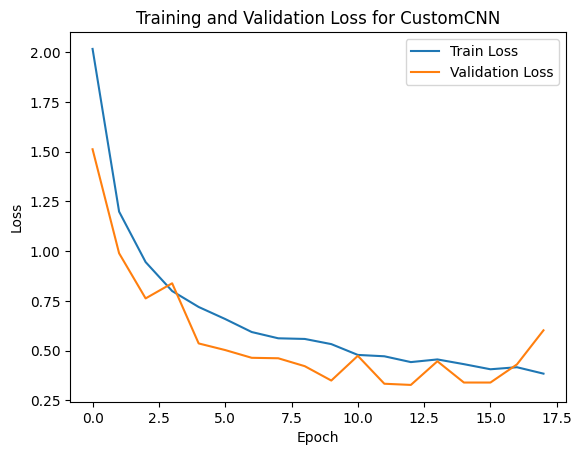

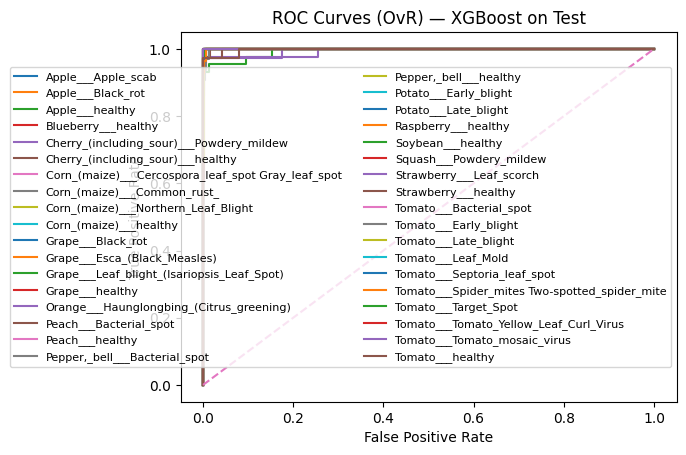

In [17]:
# Cell-13
# Plotting loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss for CustomCNN")
plt.show()

# Optional: plot OvR ROC (example for XGBoost)
try:
    P = proba(xgb_clf, X_test)
    for i, cls in enumerate(class_names):
        fpr, tpr, _ = roc_curve(Y_test_ovr[:, i], P[:, i])
        plt.plot(fpr, tpr, label=f"{cls}")
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (OvR) — XGBoost on Test")
    plt.legend(ncol=2, fontsize=8)
    plt.show()
except Exception as e:
    print("ROC plot skipped:", e)
